In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import cPickle as pickle
from vespa import FPPCalculation, PopulationSet
from vespa.transit_basic import traptransit
from corner import corner

from vespa.populations import ArtificialPopulation, BoxyModel, LongModel

import logging
rootLogger = logging.getLogger()
rootLogger.setLevel(logging.DEBUG)

In [2]:
#koi = 'K05625.01'
#koi = 'K01204.01'
koi = 'K02857.02'
fpp = FPPCalculation.from_ini(koi)
boxmodel = BoxyModel(10./2e5, fpp['pl'].stars.slope.quantile(0.99))
longmodel = LongModel(10./2e5, fpp['pl'].stars.duration.quantile(0.99))

fpp.add_population(boxmodel)
fpp.add_population(longmodel)

INFO:root:Single StarModel loaded from /Users/tdm/repositories/koi-fpp/K02857.02/dartmouth_starmodel_single.h5
INFO:root:BinaryStarModel loaded from /Users/tdm/repositories/koi-fpp/K02857.02/dartmouth_starmodel_binary.h5
INFO:root:TripleStarModel loaded from /Users/tdm/repositories/koi-fpp/K02857.02/dartmouth_starmodel_triple.h5
INFO:root:Loading transit signal from /Users/tdm/repositories/koi-fpp/K02857.02/trsig.pkl...
INFO:root:PopulationSet loaded from /Users/tdm/repositories/koi-fpp/K02857.02/popset.h5


In [3]:
fpp2 = FPPCalculation(fpp.trsig, fpp.popset.resample())

In [9]:
c = fpp['eb'].constraints['secondary depth']
c2 = fpp2['eb'].constraints['secondary depth']

In [10]:
c.N

20000

In [11]:
c2.N

20000

In [12]:
c.frac

0.18325

In [13]:
c2.frac

0.18555

In [18]:
fpp.prior('heb')

0.0020724643788372246

In [19]:
fpp2.prior('heb')

0.002073000869745544

In [3]:
c = fpp['eb'].constraints['secondary depth']

In [4]:
c2 = c.resample([1,2,3,4])

In [8]:
c2.name

'secondary depth'

In [4]:
c.arrays

('ok', 'vals')

In [3]:
rootLogger.setLevel(logging.DEBUG)
fpp.FPP()

DEBUG:root:evaluating likelihoods for K02857.02
DEBUG:root:BEBs: 3.45e-10 = 1.52e-03 (prior) x 2.27e-07 (lhood)
DEBUG:root:BEBs (Double Period): 1.29e-09 = 1.19e-03 (prior) x 1.08e-06 (lhood)
DEBUG:root:EBs: 1.96e-15 = 9.55e-03 (prior) x 2.05e-13 (lhood)
DEBUG:root:EBs (Double Period): 4.36e-11 = 1.36e-04 (prior) x 3.20e-07 (lhood)
DEBUG:root:HEBs: 1.69e-27 = 2.07e-03 (prior) x 8.15e-25 (lhood)
DEBUG:root:HEBs (Double Period): 2.65e-11 = 2.77e-05 (prior) x 9.55e-07 (lhood)
DEBUG:root:boxy: 6.34e-06 = 5.00e-04 (prior) x 1.27e-02 (lhood)
DEBUG:root:long: 0.00e+00 = 5.00e-04 (prior) x 0.00e+00 (lhood)
DEBUG:root:planet: 5.60e-03 = 1.44e-02 (prior) x 3.89e-01 (lhood)


0.0011305519616935378

In [44]:
def boxy(x, min_slope=10, max_slope=15, logd_range=(-5,0), dur_range=(0,2)):
    """x has shape (3, N), where N is number of shape samples
    
    in 0th dimension, params are duration, logd, slope
    
    flat between min_slope & max_slope, zero below min_slope
    """
    level = 1./((logd_range[1]-logd_range[0])*(dur_range[1]-dur_range[0])*(max_slope-min_slope))
    return level*(x[2,:] > min_slope)

def longdur(x, min_dur=0.5, max_dur=2, slope_range=(2,15), logd_range=(-5,0)):
    """
    flat between min_dur and max_dur, zero below min_dur
    """
    level = 1./((logd_range[1]-logd_range[0])*(slope_range[1]-slope_range[0])*(max_dur-min_dur))
    return level*(x[0,:] > min_dur)

class BoxyModel(ArtificialPopulation):
    max_slope = 15
    logd_range = (-5,0)
    dur_range = (0,2)
    model='boxy'
    modelshort='boxy'

    def __init__(self, prior, min_slope):
        self._prior = prior
        self.min_slope = min_slope
        
    def _lhoodfn(self, x):
        level = 1./((self.logd_range[1]-self.logd_range[0])*
                    (self.dur_range[1]-self.dur_range[0])*
                    (self.max_slope-self.min_slope))
        return level*(x[2,:] > self.min_slope)
        
        
class LongModel(ArtificialPopulation):
    slope_range = (2,15)
    logd_range = (0,5)
    max_dur = 2.
    model='long'
    modelshort='long'
    
    def __init__(self, prior, min_dur):
        self._prior = prior
        self.min_dur = min_dur
        
    def _lhoodfn(self, x):
        level = 1./((self.logd_range[1]-self.logd_range[0])*
                    (self.slope_range[1]-self.slope_range[0])*
                    (self.max_dur-self.min_dur))
        return level*(x[0,:] > self.min_dur)
        

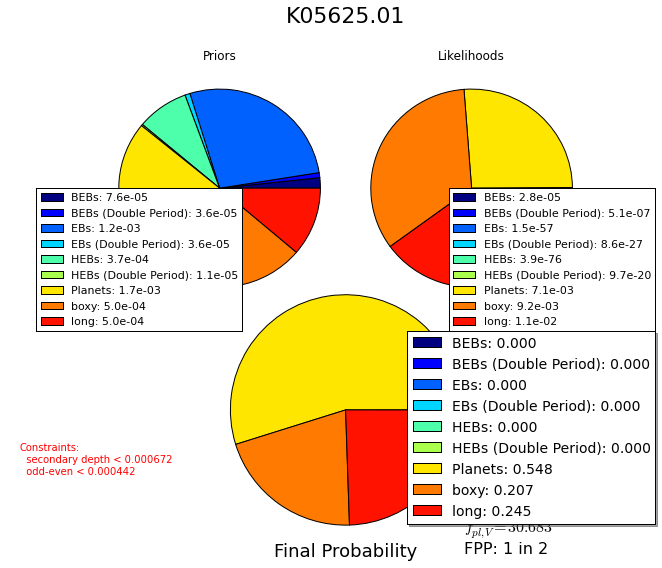

In [41]:
rootLogger.setLevel(logging.INFO)
fpp.FPPsummary()

In [75]:
print BoxyModel(1./len(fpp.popset.poplist), fpp['pl'].stars.slope.quantile(0.99)).lhood(fpp.trsig)
print LongModel(1./len(fpp.popset.poplist), fpp['pl'].stars.duration.quantile(0.99)).lhood(fpp.trsig)
print fpp.lhood('pl')

0.0092333533057
0.0109116808503
0.00712458112352


In [58]:
print fpp['pl'].stars.duration.quantile(0.99)
print fpp['pl'].stars.slope.quantile(0.99)

0.359055892503
7.85744535884


In [50]:
fpp['pl'].stars.slope.mean()

5.4445165815508112

In [42]:
fpp.lhood('pl')

0.00712458

In [15]:
boxy(fpp.trsig.kde.dataset).sum()

137.01999999999998

In [21]:
fpp.trsig.kde.dataset.shape

(3, 10000)

In [46]:
fpp = FPPCalculation.from_ini('K01204.01')

In [21]:
longdur(fpp.trsig.kde.dataset, 0.34).sum()

82.205746061167758

In [17]:
fpp['pl'].stars.duration.mean()

0.17056108470468098

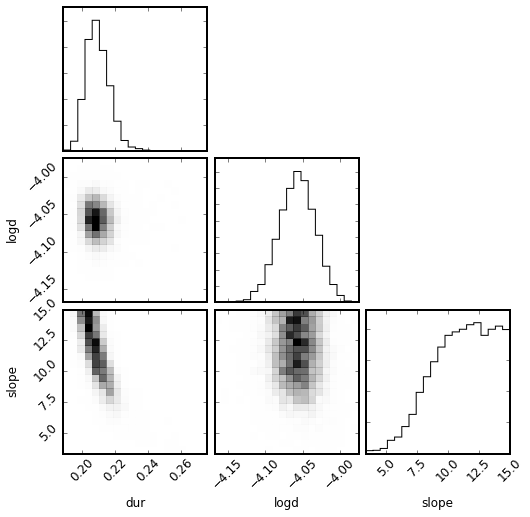

In [14]:
fpp = FPPCalculation.from_ini('K02857.02')
fig = corner(fpp.trsig.kde.dataset.T, labels=['dur', 'logd', 'slope'], plot_contours=False);
fpp.lhood('pl');

0.0059437977822457428

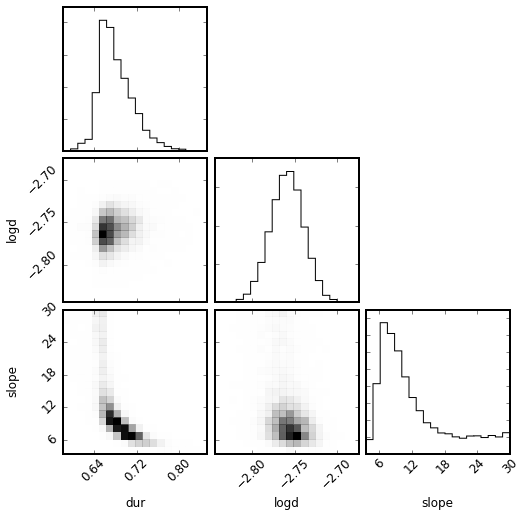

In [16]:
fpp.trsig.MCMC(refit=True, maxslope=30)
corner(fpp.trsig.kde.dataset.T, labels=['dur', 'logd', 'slope'], plot_contours=False);
fpp.lhood('pl')

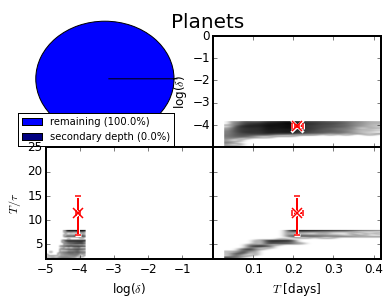

In [6]:
fpp.lhoodplot('pl')

In [11]:
y = fpp['pl'].kde(fpp.trsig.kde.dataset)
y.sum()/len(y)

0.007985514928750605

In [14]:
def lhood_hist(koi):
    fpp = FPPCalculation.from_ini(koi)

    pl = fpp['pl']
    sig = fpp.trsig
    y = pl.kde(sig.kde.dataset)
    print(y.sum()/len(y))
    pl.lhoodplot(sig)
    plt.figure()
    plt.hist(np.log(y[y>0]));
    corner(sig.kde.dataset.T, labels=['duration', 'log(depth)', 'slope'], plot_contours=False);
    sig.plot(plot_trap=True)
    return y

OK, so these FPP calculations depend on calculations of this kind.  I obtain ~10,000 trapezoidal shape samples via Monte Carlo simulation of a physical eclipse scenario model (in this case, the scenario of a planet transiting a given target star), which I use to estimate the 3d probability density of the shape parameters under this model: $\mathcal L(\theta)$.  I also obtain $N$ samples from the posterior $\{p_k\}$ of the trapezoidal shape parameters $\theta$ via MCMC on the observed data.

I then calculate what I call the "likelihood" of this scenario (which is actually more like the evidence) as follows:

$$ Z \approx \frac{1}{N}  \sum_{k=1}^N \mathcal L(p_k) $$

Below illustrates these calculations for three different KOIs.  From visual inspection it seems like the first (1204.01) should be the worst, since it's way off on duration.  

0.01432338295


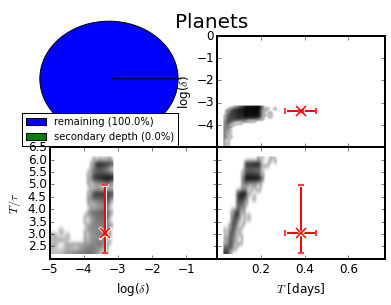

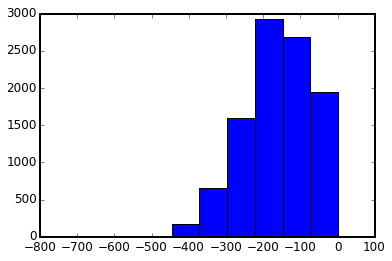

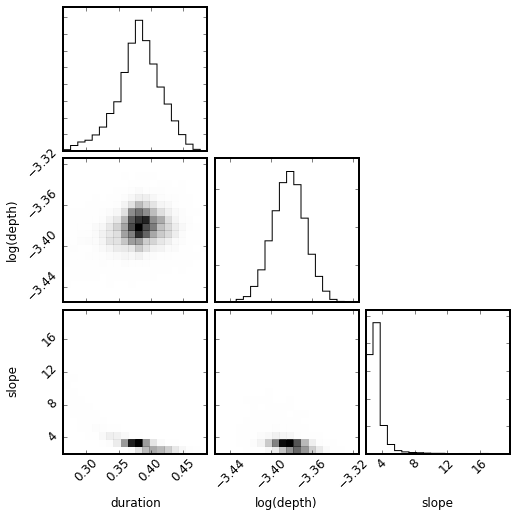

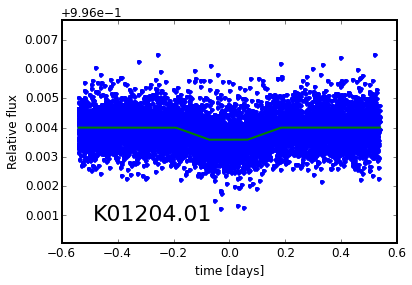

In [15]:
y0 = lhood_hist('K01204.01')

0.123882267032


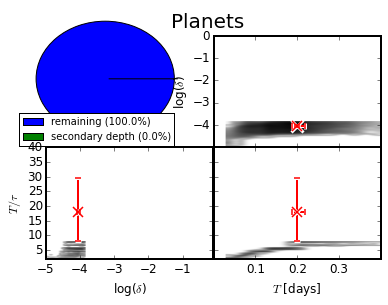

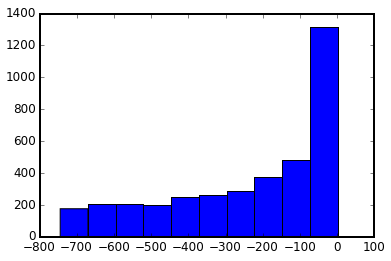

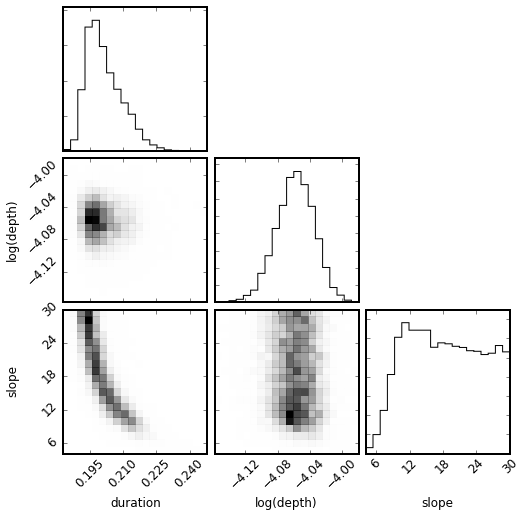

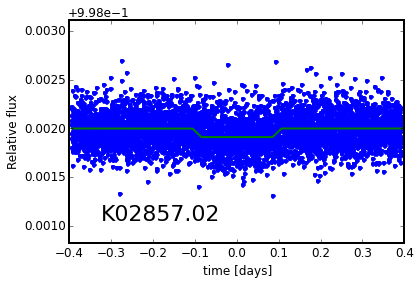

In [16]:
y1 = lhood_hist('K02857.02')

0.00580696277346


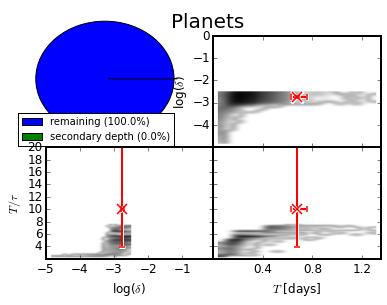

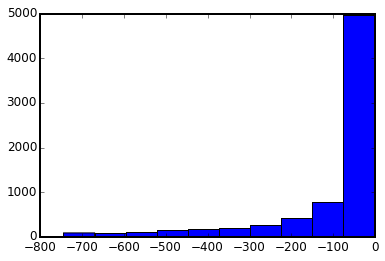

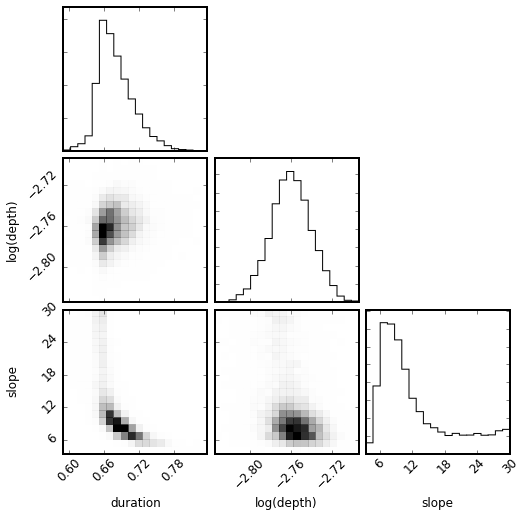

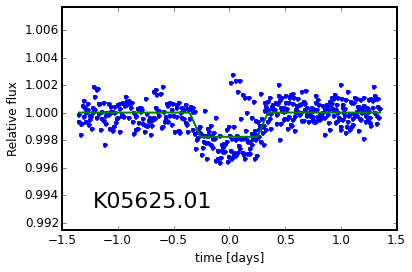

In [17]:
y2 = lhood_hist('K05625.01')

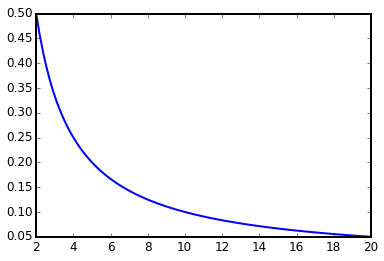

In [20]:
smin = 2; smax=20
s = np.linspace(smin,smax,100)
plt.plot(s, 1./s)